## Let's start with the imports

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import json
import pickle
import urllib

from sklearn.preprocessing import MultiLabelBinarizer

print(tf.__version__)

# Download the data from GCS
!wget 'https://storage.googleapis.com/movies_data/movies_metadata.csv'

top_genres = ['Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Documentary', 'Adventure', 'Science Fiction']

data = pd.read_csv('movies_metadata.csv')


W0406 03:50:26.303824 140571099002752 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1
--2019-04-06 03:50:27--  https://storage.googleapis.com/movies_data/movies_metadata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34445126 (33M) [application/octet-stream]
Saving to: ‘movies_metadata.csv.2’

movies_metadata.csv 100%[===================>]  32.85M   134MB/s    in 0.2s    

2019-04-06 03:50:27 (134 MB/s) - ‘movies_metadata.csv.2’ saved [34445126/34445126]



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
print('Total number of movies: ',len(data))
print('total number of NaN in the column genres : ',data['genres'].isnull().sum())
print('total number of NaN in the column overview : ',data['overview'].isnull().sum())

# Remove the missing values
missing_idx = data[data['overview'].isnull()==True].index
dat = data.drop(missing_idx)
dat = dat.reset_index(drop=True)

dat = dat[:2500] # subset like this for example
dat.head(3)

Total number of movies:  45466
total number of NaN in the column genres :  0
total number of NaN in the column overview :  954


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


## Data Preparation

A sample of 2500 movies is selected from the original dataset. It seems that each movie could have more than one genres. We would want to check out the genres we have and reorganize them to be the target variable we could use for the prediction.

In [0]:
genres = dat['genres']
movies_genres = []

for i in range(len(dat['genres'])):
    a = genres[i].split("'name': ")
    a_genres = []
    if len(a) > 2:
        for j in range(len(a)-1):
            a_genres.append(a[j+1].split('},')[0].split("'")[1])
    elif len(a) == 2:
        a_genres.append(a[1].split('},')[0].split("'")[1])
    elif len(a) == 1:
        a_genres.append('')
    movies_genres.append(a_genres)

In [0]:
# Build a new dataframe used for the model
new_dat_dict = {'genres':movies_genres,'summary':dat['overview'].values}
new_dat = pd.DataFrame(new_dat_dict)
new_dat.head(2)

,genres,summary
0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ..."
1,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...


In [0]:
# The index of the movie with empty genre
empty_idx = [i for i,gen in enumerate(movies_genres) if gen[0]=='']
modified_genres = []
print('Number of Empty genre index: ',len(empty_idx))
new_dat = new_dat.drop(empty_idx)
new_dat = new_dat.reset_index(drop=True)

Number of Empty genre index:  62


In [0]:
movies_genres = list(new_dat['genres'].values)
# Flatten all the genres and find out the unique genres of the movies we choose
def flatten(list):
    for i in list:
        for j in i:
            yield j
all_genres = list(flatten(movies_genres))

# The unique genres of our selected sample
print(set(all_genres))

{'Horror', 'Documentary', 'Crime', 'Drama', 'Science Fiction', 'Animation', 'Mystery', 'Foreign', 'Action', 'Thriller', 'Music', 'Adventure', 'Romance', 'Western', 'History', 'Comedy', 'Fantasy', 'TV Movie', 'Family', 'War'}


Now, how to select the genres we want to use for the prediction task? There are two ways. The first one is to check the correlation of the occurency among the genres assigned for these movies. And then, we could combine the genres with high occurence correlations into a new genre. However, here to save the time, I would just use the Top genres provided here for the prediction task.

We could take a look at a heat map for the occurence of each genres (Some genres would appear together for one movie).

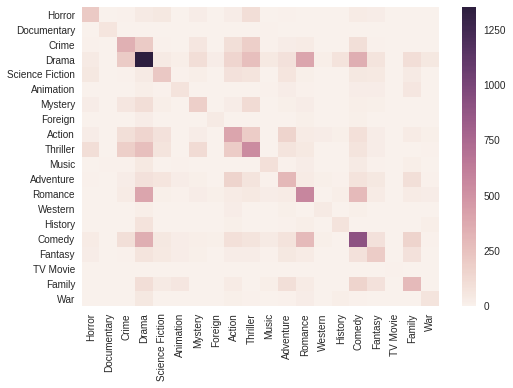

In [0]:
import seaborn as sns

# Transfer the genres to the ids
all_genres_list = list(set(all_genres))
id_set = [i for i,t in enumerate(all_genres_list)]
heat_matrix = np.zeros((len(id_set), len(id_set)))

# Add up the heat map matrix
for a1 in movies_genres:
    id = []
    for a2 in a1:
        id.append(all_genres_list.index(a2))
    for i in id:
        for j in id:
            heat_matrix[i,j] = heat_matrix[i,j]+1

# Heat map
sns.heatmap(heat_matrix, xticklabels=all_genres_list, yticklabels=all_genres_list)

Let's modify the dataset again to keep the movies we want for the training based on the top genres we set.

In [0]:
# Select the movies with only one genre matching the Top genres we set
new_genres = []

for gens in movies_genres:
    new_gen = [a for a in gens if a in top_genres]
    new_genres.append(new_gen)
    
one_idx = [i for i,t in enumerate(new_genres) if len(t)==1 and t is not '']
one_genre = [t[0] for i,t in enumerate(new_genres) if len(t)==1 and t is not '']

939 movies are selected here for the model building to do the prediction. The target would only have one genre. Limited to the time here, I would only deal with such a simple target response variable.

In [0]:
# Add the Target Genre into the dataframe
select_movies = new_dat.iloc[one_idx,:]
select_movies['Target Genre'] = one_genre
select_movies.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,genres,summary,Target Genre
0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",Comedy
1,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,Adventure


## Text to Numerical Vector

Now it is the time to modify the predict variable, whcih is the summary of the movie. The summary of the movie contains short sentences. We need to transfer these sentences into numerical vectors of wrods.

To make the texts usable and meaningful, we need to do three steps. The first step is to transfer all the texts into a frequency matrix. Here I just use the naive way, which is the bag of words tech that count the appearing fequency for each word in all the summary sentences. Use the package 'CountVectorizer', we could easily do that. 

However, not every word is meaningful. So the second step is that we would want get rid of the words that appear too often in all the sentences and the words that appear too seldom (Too unique for each movie, might not be general when we try to train a prediction model). 

The third step is to give a weight indicating the importance of the word. For the meaningful words, the word appears too often would still be less important, such as 'about', 'for'. They would have a smaller weight. But in the low-frequent words, the word appears more times would be relatively important (indicate some features). We would simply apply 'TfidfTransformer' package to help us assign all the weightage.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

summaries = list(select_movies['summary'].values) # All summary contents
vectorize=CountVectorizer(max_df=0.95, min_df=0.005) # Remove words too frequent or too seldom
c=vectorize.fit_transform(summaries) # Modified words sparse matrix
feature_name = vectorize.get_feature_names() # The words left text
c_matrix = c.toarray() # The frequency matrix

c_sum = c_matrix.sum(axis=1)
sorted_c_sum = -np.sort(-c_sum)
# Show the top 10 frequent words and their numbers
for i in range(10):
    print(feature_name[(-c_sum).argsort()[i]],sorted_c_sum[i])

leave 132
mysterious 124
itself 122
facing 121
release 120
escape 118
italian 116
allen 113
eccentric 110
open 107


In [0]:
# TFIDF giving the weights
tfidf_transformer = TfidfTransformer()
c_tfidf = tfidf_transformer.fit_transform(c)
c_tfidf.shape
# Print the exmaple of the weights of words for the first movie
print(c_tfidf[0])

  (0, 1243)	0.09309226064272656
  (0, 1197)	0.17547728262393353
  (0, 1153)	0.053004408037103004
  (0, 1127)	0.1968990388407868
  (0, 1125)	0.09217723474207379
  (0, 973)	0.21668648925879927
  (0, 956)	0.21668648925879927
  (0, 894)	0.18403305747464013
  (0, 847)	0.18247310471053643
  (0, 822)	0.19096773627929087
  (0, 807)	0.24079475109754778
  (0, 794)	0.05389957778946743
  (0, 680)	0.22466790471234804
  (0, 665)	0.1695298527335692
  (0, 651)	0.2070945826644906
  (0, 647)	0.20178354550396874
  (0, 562)	0.11768316484717199
  (0, 530)	0.1432548785440303
  (0, 512)	0.21322572510815838
  (0, 502)	0.23466360865388003
  (0, 449)	0.09882123892113999
  (0, 368)	0.18247310471053643
  (0, 335)	0.22935257149335816
  (0, 211)	0.22047732747869384
  (0, 168)	0.09277020465576531
  (0, 166)	0.09882123892113999
  (0, 152)	0.2070945826644906
  (0, 135)	0.23466360865388003
  (0, 62)	0.049342530850189685
  (0, 35)	0.18247310471053643
  (0, 30)	0.24079475109754778


## Statistics Model Training

In [0]:
from sklearn.model_selection import train_test_split

# Split the training and test sets
y_gens = select_movies['Target Genre'].values
y = [top_genres.index(a) for a in y_gens]
X = [i for i in range(len(select_movies))]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

c_tfidf_train = c_tfidf[X_train]
c_tfidf_test = c_tfidf[X_test]

c_train = c[X_train].toarray()
c_test = c[X_test].toarray()

### Multinomial Naive Bayes

###Use the frequency matrix to train the model

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

alpha = np.linspace(1,3,30)
clf = GridSearchCV(MultinomialNB(), {'alpha':list(alpha)}, scoring='accuracy')
clf.fit(c_train, y_train)

nb_train_predict = clf.predict(c_train)
nb_test_predict = clf.predict(c_test)

train_acc = sum(nb_train_predict==y_train)/len(y_train)
test_acc = sum(nb_test_predict==y_test)/len(y_test)

print('Training Accuracy: ',train_acc,' Test Accuracy: ',test_acc)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Training Accuracy:  0.8843226788432268  Test Accuracy:  0.48936170212765956


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
# Show the Accuracy for each genre
for i in range(len(top_genres)):
    idxs_train = [idx for idx,a in enumerate(y_train) if a==i]
    y_train_i = [y_train[idx] for idx in idxs_train]
    nb_train_predict_i = [nb_train_predict[idx] for idx in idxs_train]
    idxs_test = [idx for idx,a in enumerate(y_test) if a==i]
    y_test_i = [y_test[idx] for idx in idxs_test]
    nb_test_predict_i = [nb_test_predict[idx] for idx in idxs_test]
    print('Number of Genre ',top_genres[i],' is ',len(y_train_i),', Training Accuracy is ',\
          sum(np.array(nb_train_predict_i)==np.array(y_train_i))/len(y_train_i),\
          ', Testing Accuracy is ',sum(np.array(nb_test_predict_i)==np.array(y_test_i))/len(y_test_i))

Number of Genre  Comedy  is  253 , Training Accuracy is  0.9130434782608695 , Testing Accuracy is  0.6885245901639344
Number of Genre  Thriller  is  59 , Training Accuracy is  0.9152542372881356 , Testing Accuracy is  0.23076923076923078
Number of Genre  Romance  is  148 , Training Accuracy is  0.9662162162162162 , Testing Accuracy is  0.6206896551724138
Number of Genre  Action  is  18 , Training Accuracy is  0.5 , Testing Accuracy is  0.0
Number of Genre  Horror  is  35 , Training Accuracy is  0.7142857142857143 , Testing Accuracy is  0.0
Number of Genre  Crime  is  38 , Training Accuracy is  0.8421052631578947 , Testing Accuracy is  0.0
Number of Genre  Documentary  is  41 , Training Accuracy is  0.9512195121951219 , Testing Accuracy is  0.5
Number of Genre  Adventure  is  49 , Training Accuracy is  0.8979591836734694 , Testing Accuracy is  0.13333333333333333
Number of Genre  Science Fiction  is  16 , Training Accuracy is  0.25 , Testing Accuracy is  0.0


### Use the weightages to train the model

In [0]:
alpha = np.linspace(1,3,30)
clf = GridSearchCV(MultinomialNB(), {'alpha':list(alpha)}, scoring='accuracy')
clf.fit(c_train, y_train)

nb_train_predict = clf.predict(c_tfidf_train)
nb_test_predict = clf.predict(c_tfidf_test)

train_acc = sum(nb_train_predict==y_train)/len(y_train)
test_acc = sum(nb_test_predict==y_test)/len(y_test)

print('Training Accuracy: ',train_acc,' Test Accuracy: ',test_acc)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Training Accuracy:  0.8767123287671232  Test Accuracy:  0.4929078014184397


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
# Show the Accuracy for each genre
for i in range(len(top_genres)):
    idxs_train = [idx for idx,a in enumerate(y_train) if a==i]
    y_train_i = [y_train[idx] for idx in idxs_train]
    nb_train_predict_i = [nb_train_predict[idx] for idx in idxs_train]
    idxs_test = [idx for idx,a in enumerate(y_test) if a==i]
    y_test_i = [y_test[idx] for idx in idxs_test]
    nb_test_predict_i = [nb_test_predict[idx] for idx in idxs_test]
    print('Number of Genre ',top_genres[i],' is ',len(y_train_i),', Training Accuracy is ',\
          sum(np.array(nb_train_predict_i)==np.array(y_train_i))/len(y_train_i),\
          ', Testing Accuracy is ',sum(np.array(nb_test_predict_i)==np.array(y_test_i))/len(y_test_i))

Number of Genre  Comedy  is  253 , Training Accuracy is  0.9802371541501976 , Testing Accuracy is  0.819672131147541
Number of Genre  Thriller  is  59 , Training Accuracy is  0.8305084745762712 , Testing Accuracy is  0.07692307692307693
Number of Genre  Romance  is  148 , Training Accuracy is  0.9256756756756757 , Testing Accuracy is  0.4827586206896552
Number of Genre  Action  is  18 , Training Accuracy is  0.3888888888888889 , Testing Accuracy is  0.0
Number of Genre  Horror  is  35 , Training Accuracy is  0.7428571428571429 , Testing Accuracy is  0.18181818181818182
Number of Genre  Crime  is  38 , Training Accuracy is  0.7368421052631579 , Testing Accuracy is  0.0
Number of Genre  Documentary  is  41 , Training Accuracy is  0.9024390243902439 , Testing Accuracy is  0.3
Number of Genre  Adventure  is  49 , Training Accuracy is  0.8163265306122449 , Testing Accuracy is  0.06666666666666667
Number of Genre  Science Fiction  is  16 , Training Accuracy is  0.25 , Testing Accuracy is  0.

## Deep Nueral Network Model

I'm not very familiar with the tensorhub, so here I just did a 3-layer fully condensed network model to do the prediction. It is coded in tensorflow.

In [0]:
def lrelu(x, leak=0.2, name="lrelu"):
    # The function is used to construct one simple Leaky Relu layer in tensorflow
    # Remeber to specify one unique name for one layer
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    # The function is used to construct one simple Fully Connected layer in tensorflow
    # Remeber to specify one unique name for one layer
    shape = input_.get_shape().as_list()
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

###Data modification and the parameters setting.

In [0]:
y_train_onehot = np.zeros((len(y_train),9))
y_test_onehot = np.zeros((len(y_test),9))

for i in range(len(y_train)):
    y_train_onehot[i,y_train[i]] = 1

for i in range(len(y_test)):
    y_test_onehot[i,y_test[i]] = 1

num_epoch = 15
input_size = c_train.shape[1]
output_size = 9
batch_size = 30

###Set up the network structure and variables.

In [0]:
device_name = "/gpu:0"
with tf.device(device_name):
    # Input Variable
    x = tf.placeholder(tf.float32, shape=(batch_size, input_size))
    y = tf.placeholder(tf.float32, shape=(batch_size, output_size))
    y_label = tf.argmax(y, dimension=1)
    # Networks
    h1 = linear(x,input_size*12,scope='dense1')
    h1 = lrelu(h1,leak=0.1,name='relu1')
    h2 = linear(h1,input_size*12,scope='dense2')
    h2 = lrelu(h2,leak=0.1,name='relu2')
    h3 = linear(h2,output_size,scope='dense3')
    output = tf.nn.sigmoid(h3)
    predict_label = tf.argmax(output, dimension=1)
    # Loss
    loss = tf.reduce_mean(tf.keras.backend.binary_crossentropy(y,output),keep_dims=False)
    # Accuracy
    correct_prediction = tf.equal(predict_label, y_label)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use the `axis` argument instead


W0406 03:50:34.476244 140571099002752 deprecation.py:506] From <ipython-input-19-5c872b2b6e71>:6: calling argmax (from tensorflow.python.ops.math_ops) with dimension is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


Instructions for updating:
Colocations handled automatically by placer.


W0406 03:50:34.509139 140571099002752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


###The main training process.

In [0]:
# The parameters for the optimization method
lr=0.0002
beta1=0.5
optim = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(loss)

# For the batch
batch_train_idxs = len(y_train) // batch_size
batch_test_idxs = len(y_test) // batch_size
batch_train_loss = batch_test_loss = batch_train_acc = batch_test_acc = 0

# Train and Test Loss and Accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# Train the model
with tf.Session() as sess:
    
    # Initalize the variables
    sess.run(tf.global_variables_initializer())
    
    # Do the training process
    for epoch in range(num_epoch):
        
        # Train for each batch
        for idx in range(0, batch_train_idxs):
            batch_data = c_train[idx * batch_size:(idx + 1) * batch_size, :]
            batch_y = y_train_onehot[idx * batch_size:(idx + 1) * batch_size, :]
            # Train the Networks
            sess.run(optim, {x:batch_data, y:batch_y})
            # Calculate the loss
            loss_train = sess.run(loss, {x:batch_data, y:batch_y})
            batch_train_loss += loss_train
            # Calculate the accuracy
            acc_train = sess.run(accuracy, {x:batch_data, y:batch_y})
            batch_train_acc += acc_train
        
        # Test loss and accuracy
        for idx in range(0, batch_test_idxs):
            batch_data = c_test[idx * batch_size:(idx + 1) * batch_size, :]
            batch_y = y_test_onehot[idx * batch_size:(idx + 1) * batch_size, :]
            # Calculate the loss
            loss_test = sess.run(loss, {x:batch_data, y:batch_y})
            batch_test_loss += loss_test
            # Calculate the accuracy   
            acc_test = sess.run(accuracy, {x:batch_data, y:batch_y})
            batch_test_acc += acc_test
        
        batch_train_loss /= batch_train_idxs
        batch_test_loss /= batch_test_idxs
        batch_train_acc /= batch_train_idxs
        batch_test_acc /= batch_test_idxs
        
        train_loss.append(batch_train_loss)
        test_loss.append(batch_test_loss)
        train_accuracy.append(batch_train_acc)
        test_accuracy.append(batch_test_acc)
                
        print('Epoch ',epoch,' averaged training loss is ',batch_train_loss,\
              ' averaged testing loss is ',batch_test_loss,\
              ' averaged testing accuracy is ',batch_test_acc)

Epoch  0  averaged training loss is  0.38553146592208315  averaged testing loss is  0.3702162222729789  averaged testing accuracy is  0.3777777867184745
Epoch  1  averaged training loss is  0.09992451200477122  averaged testing loss is  0.36895167183728866  averaged testing accuracy is  0.4901234608741454
Epoch  2  averaged training loss is  0.037894645962257154  averaged testing loss is  0.40657466909604145  averaged testing accuracy is  0.498902618353586
Epoch  3  averaged training loss is  0.01739006045032063  averaged testing loss is  0.536061664710792  averaged testing accuracy is  0.46284104049923475
Epoch  4  averaged training loss is  0.007758409792796732  averaged testing loss is  0.49385512761389233  averaged testing accuracy is  0.48476011958466914
Epoch  5  averaged training loss is  0.004693838516350349  averaged testing loss is  0.5111310508429067  averaged testing accuracy is  0.4946029797822755
Epoch  6  averaged training loss is  0.003182988834705181  averaged testing 